In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
BERT_MODEL = 'bert-base-uncased'

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tqdm
import os
import tests

# Split train set 

In [ ]:
DATA_PATH = './'

train = pd.read_json('train_set.json')
train_df, val_df = train_test_split(train, random_state=42, stratify=train['label'], test_size=0.05)

In [ ]:
train_df.shape, val_df.shape

((3800, 3), (200, 3))

In [ ]:
train_df

,id,text,label
3012,3012,Meet the Australian families who have pet kang...,1
1436,1436,"Kurree Sharif, Kurree Sharif is a lar`ge villa...",1
96,96,"John Allen Hemphill (December 19, 1927 – Octob...",0
43,43,"Paul Stephen Ranheim (born January 25, 1966) i...",0
1814,1814,"girl, named locally as leah price, was airlift...",0
...,...,...,...
1130,1130,A test in Kansas finds listeria in a Blue Bell...,1
1294,1294,"Leroy David Baca (born May 27, 1942) is a reti...",0
860,860,Ana María Gayoso (20 August 1948 – 10 December...,0
3507,3507,Angeline Mabula (born 6 May 1962) is a Zambian...,0


# Preprocessing

We tokenize the original documents and summaries using BERT tokenizer

In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL)

In [ ]:
tqdm.tqdm.pandas()

train_df['enc'] = train_df.progress_apply(lambda x: tokenizer.encode(x['text']), axis=1)

100%|██████████| 3800/3800 [00:02<00:00, 1705.65it/s]


In [ ]:
tqdm.tqdm.pandas()

val_df['enc'] = val_df.progress_apply(lambda x: tokenizer.encode(x['text']), axis=1)

100%|██████████| 200/200 [00:00<00:00, 2109.48it/s]


In [ ]:
train_df.head()

,id,text,label,enc
3648,3648,"Nurhayada Sofia, six, was dragged by escalator...",0,"[101, 27617, 26115, 2850, 8755, 1010, 2416, 10..."
1039,1039,Boy named Shiva was found in possession of sto...,1,"[101, 2879, 2315, 12535, 2001, 2179, 1999, 666..."
529,529,Two men had made the DIY boat at their home us...,1,"[101, 2048, 2273, 2018, 2081, 1996, 4487, 2100..."
638,638,Just The Flight have researched city nicknames...,0,"[101, 2074, 1996, 3462, 2031, 18800, 2103, 836..."
3376,3376,Most girls grow out of their yearning for tumb...,1,"[101, 2087, 3057, 4982, 2041, 1997, 2037, 2947..."


# Create dataset

In [ ]:
from torch.utils.data import Dataset
import torch

class MyDataset(Dataset):
    
    def __init__(self, corpus, targets):
        super(MyDataset, self).__init__()
        self.corpus = corpus.copy()
        self.targets = targets
        for i, ids in enumerate(corpus):
            if len(ids) > 512:
                self.corpus.iloc[i] = ids[:512] 
        
    def __len__(self):
        return len(self.corpus)
    
    def __getitem__(self, idx):
        """
        Returns:
            obj: (input_ids, target)
        """
        return (torch.LongTensor(self.corpus.iloc[idx]), self.targets.iloc[idx])

In [ ]:
dataset = MyDataset(corpus=train_df['enc'], targets=train_df['label'])

In [ ]:
len(dataset)

3800

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch, pad_idx=0):
    """
        Args:
            batch: list of objects
            pad_idx: padding idx
        Returns:
            padded ids, token_type_ids, labels
    """

    padded_ids = []
    labels = []
    for input_id, label in batch:
        padded_ids.append(input_id)
        labels.append(label)
    padded_ids = pad_sequence(padded_ids, batch_first=True, padding_value=pad_idx)
    return torch.LongTensor(padded_ids), torch.LongTensor(labels)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [ ]:
from transformers import BertModel

In [ ]:
from torch import nn
import torch

class BERTClassifier(nn.Module):

    def __init__(self, bert, n_classes=1):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.n_classes = n_classes
        self.dropout = nn.Dropout(0.1)
        self.relu =  nn.ReLU()
        self.fc1 = nn.Linear(768, 384)
        self.fc2 = nn.Linear(384, self.n_classes)
        if self.n_classes > 1:    
            self.make_proba = nn.LogSoftmax(dim=1) 
        else:
            self.make_proba = nn.Sigmoid()

    @classmethod
    def from_pretrained(cls, path, n_classes=1):
        bert = BertModel.from_pretrained(path)
        return cls(bert, n_classes)
        
    def forward(self, input_ids, attention_mask=None):
        """
            Args:
                input_ids: token ids, shape = [batch_size, sequence_length]
            Returns:
                predictions, shape [batch_size]
        """
        cls_hs = self.bert(input_ids, attention_mask=attention_mask)
        x = self.fc1(cls_hs.last_hidden_state)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.squeeze(x, dim=1)
        x = torch.mean(x, dim=1)
        x = self.make_proba(x).reshape(-1)
        return x

    def predict_proba(self, input_ids, attention_mask=None):
        cls_hs = self.bert(input_ids, attention_mask=attention_mask)
        x = self.fc1(cls_hs.last_hidden_state)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.squeeze(x, dim=1)
        x = torch.mean(x, dim=1).reshape(-1)
        return x

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Optimization

In [ ]:
NO_DECAY = ['bias', 'LayerNorm.weight']

In [ ]:
def is_backbone(name):
    if name.startswith('bert'):
        return 1
    else:
        return 0

def needs_decay(name):
    for no_decay in NO_DECAY:
        if name.endswith(no_decay):
            return 0
    return 1          

def get_optimizer(model, lr, weight_decay, head_lr):
    grouped_parameters = [
        {
            'params': [param for name, param in model.named_parameters() if is_backbone(name) and needs_decay(name)],
            'lr': lr,
            'weight_decay': weight_decay,
        },
        {
            'params': [param for name, param in model.named_parameters() if is_backbone(name) and not needs_decay(name)],
            'lr': lr,
            'weight_decay': 0.,
        },
        {
            'params': [param for name, param in model.named_parameters() if not is_backbone(name)],
            'lr': head_lr,
            'weight_decay': weight_decay,
        }
    ]

    optimizer = torch.optim.AdamW(grouped_parameters, lr, weight_decay=weight_decay)

    return optimizer

LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.1
HEAD_LEARNING_RATE = 0.1

optimizer = get_optimizer(model, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, head_lr=HEAD_LEARNING_RATE)

In [ ]:
import transformers

def get_scheduler(optimizer, dataloader, n_epochs, accumulation_steps, warmup_percentage):
    num_training_steps = n_epochs*len(dataloader)/accumulation_steps
    num_warmup_steps = warmup_percentage*num_training_steps
    return transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)


N_EPOCHS = 5
ACCUMULATION_STEPS = 2
WARMUP_PERCENTAGE = 0.06

scheduler = get_scheduler(
   optimizer, dataloader, n_epochs=N_EPOCHS, accumulation_steps=ACCUMULATION_STEPS, warmup_percentage=WARMUP_PERCENTAGE
)

# Training

In [ ]:
from tqdm.notebook import tqdm as tq
from sklearn.metrics import accuracy_score

PRINT_STEP = 50

ACCUMULATION_STEPS = 1
WARMUP_PERCENTAGE = 0.1

LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-4
HEAD_LEARNING_RATE = 2e-3

BATCH_SIZE = 8

In [ ]:
model = BERTClassifier.from_pretrained(BERT_MODEL, n_classes=1).to(device)
optimizer = get_optimizer(model, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, 
                          head_lr=HEAD_LEARNING_RATE)

train_loader = DataLoader(dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)

scheduler = get_scheduler(
    optimizer, train_loader, n_epochs=N_EPOCHS, accumulation_steps=ACCUMULATION_STEPS,
    warmup_percentage=WARMUP_PERCENTAGE
)
criterion = nn.BCEWithLogitsLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
ds_val = MyDataset(corpus=val_df['enc'], targets=val_df['label'])
val_loader = DataLoader(ds_val, collate_fn=collate_fn, batch_size=8, shuffle=False)

def validation_acc_and_loss(model, val_loader, device):
    model.eval()
    true_labels = []
    predicted_labels = []
    total_loss = 0

    with torch.no_grad():
        for step, batch in enumerate(tq(val_loader)):
            input_ids, labels = batch
            attention_mask = (input_ids != 0)
            outputs = model(input_ids.to(device), attention_mask.to(device))
            true_labels += list(labels.detach().cpu().numpy())
            predicted_labels += list(outputs.detach().cpu().numpy())
            loss = criterion(outputs, labels.to(device).float())
            total_loss += loss.item()
        # print(predicted_labels[0])
        pred_labels = []
        for c in predicted_labels:
            pred_labels.append(int(np.round(c)))
        acc = accuracy_score(true_labels, pred_labels)

        loss = total_loss / len(val_loader)
    return acc, loss

In [ ]:
len(train_loader), len(val_loader)

(475, 25)

In [ ]:
len(train_loader)/5

95.0

In [ ]:
def train_model(N_EPOCHS, model, train_loader, criterion, 
                steps_of_optimizer = 0, total_loss = 0, n = 0):
    optimizer.zero_grad()
    for epoch in tq(range(N_EPOCHS)):
        for step, batch in enumerate(tq(train_loader)):
            model.train()
            input_ids, labels = batch
            attention_mask = (input_ids != 0)
            outputs = model.predict_proba(input_ids.to(device), attention_mask.to(device))
            loss = criterion(outputs, labels.to(device).float())
            batch_loss = loss.item()/len(batch)
            total_loss += loss.item()
            n += len(batch)
            loss.backward()

            if (step + 1) % ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()
                steps_of_optimizer += 1

            if step % PRINT_STEP == 0:
                iter = epoch*len(train_loader)+step
                # print(f'\r epoch {epoch + 1}/{N_EPOCHS}, 
                # step [{step}] loss train: {round(total_loss/n,3)}', end='')
                writer.add_scalar("Loss/Train", total_loss/n, iter)
                total_loss = 0

                val_acc, val_loss = validation_acc_and_loss(model, val_loader, device)
                writer.add_scalar("Loss/Val", val_loss, iter)
                writer.add_scalar("Acc/Val", val_acc, iter)
                # print(f'\r epoch {epoch + 1}/{N_EPOCHS}, step [{step}] loss val: {round(val_loss,3)}', end='')
                # print(f'\r epoch {epoch + 1}/{N_EPOCHS}, step [{step}] val acc: {round(val_acc,3)}', end='')

                torch.save(model.state_dict(), 
                           'ckpts/model_ep{}_step{}.pth'.format(epoch, step))

In [ ]:
train_model(15, model, train_loader, criterion)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
ckpt_list = sorted(os.listdir('ckpts'))
clf = BERTClassifier.from_pretrained(BERT_MODEL, n_classes=1).to(device)

accs, losses, ep_steps = [], [], []
for ckpt_path in ckpt_list:
    clf.load_state_dict(torch.load('ckpts/'+ckpt_path))
    val_acc, val_loss = validation_acc_and_loss(clf, val_loader, device)
    accs.append(val_acc)
    losses.append(val_loss)
    ep_steps.append(ckpt_path)

In [ ]:
ckpt_list

['model_ep0_step200.pth',
 'model_ep0_step250.pth',
 'model_ep0_step300.pth',
 'model_ep0_step350.pth',
 'model_ep0_step374.pth',
 'model_ep1_step100.pth',
 'model_ep1_step150.pth',
 'model_ep1_step200.pth',
 'model_ep1_step250.pth',
 'model_ep1_step300.pth',
 'model_ep1_step350.pth',
 'model_ep1_step374.pth',
 'model_ep1_step50.pth',
 'model_ep2_step0.pth']

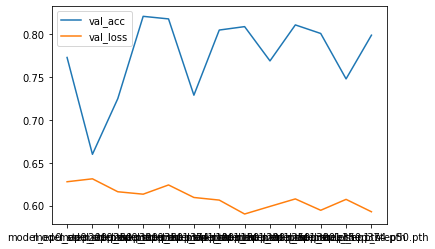

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ep_steps, accs, label='val_acc')
plt.plot(ep_steps, losses, label='val_loss')
plt.legend()

# Evaluation

## sub2

last epoch from train1

In [ ]:
train_df_all = pd.read_json('train_set.json')

In [ ]:
test_df = pd.read_json('test_set.json')
test_df['enc'] = test_df.progress_apply(lambda x: tokenizer.encode(x['text']), axis=1)

100%|██████████| 4000/4000 [00:07<00:00, 539.66it/s]


In [ ]:
BATCH_SIZE = 8
ds_test = MyDataset(corpus=test_df['enc'], targets=train_df_all['label'])
model.eval()
test_loader = DataLoader(ds_test, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=False)

true_labels = []
predicted_labels = []
for step, batch in enumerate(tq(test_loader)):
    input_ids, labels = batch
    attention_mask = (input_ids != 0)
    outputs = model(input_ids.to(device), attention_mask.to(device))
    # true_labels += list(labels.detach().cpu().numpy())
    predicted_labels += list(outputs.detach().cpu().numpy())

pred_labels = []
for c in predicted_labels:
    pred_labels.append(int(np.round(c[0])))

print('real', sum(pred_labels), 'all', len(pred_labels))

In [ ]:
import csv

# Write predictions to a file
with open("sub2.csv", "w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','label'])
    for i, row in enumerate(pred_labels):
        csv_out.writerow([i, row])

Accuracy - test

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(true_labels, pred_labels)

0.794